In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats, integrate
import os

# Global parameters

In [2]:
data_file = 0

time_bin = 0.008 # [us]
period = 2. # [us]
t0 = 1 # [us] Initial time to analysis time window 
tf = 1.5 # [us] Final time to analysis time window

t0_pos = int(t0/time_bin)
tf_pos = int(tf/time_bin)

th = 100 # [mV] Height at which we measure the time difference between LED and Signal


# Data

In [3]:
filename = []

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230414/'

filename.append(os.path.join(path, 'timeres.txt')) 

In [4]:
filename[data_file]

'/home/investigator/mariandbt/python/data/20230414/timeres.txt'

In [5]:
# DAQ without header
with open(filename[data_file]) as f:
    data = np.loadtxt(f)
f.close()

In [6]:
waveform = np.array(data)

n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  1000
n_frames =  4140


# Functions

In [7]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

# Analysis

### Mean Waveform

Let's plot the mean waveform to see the LED vs signal pattern

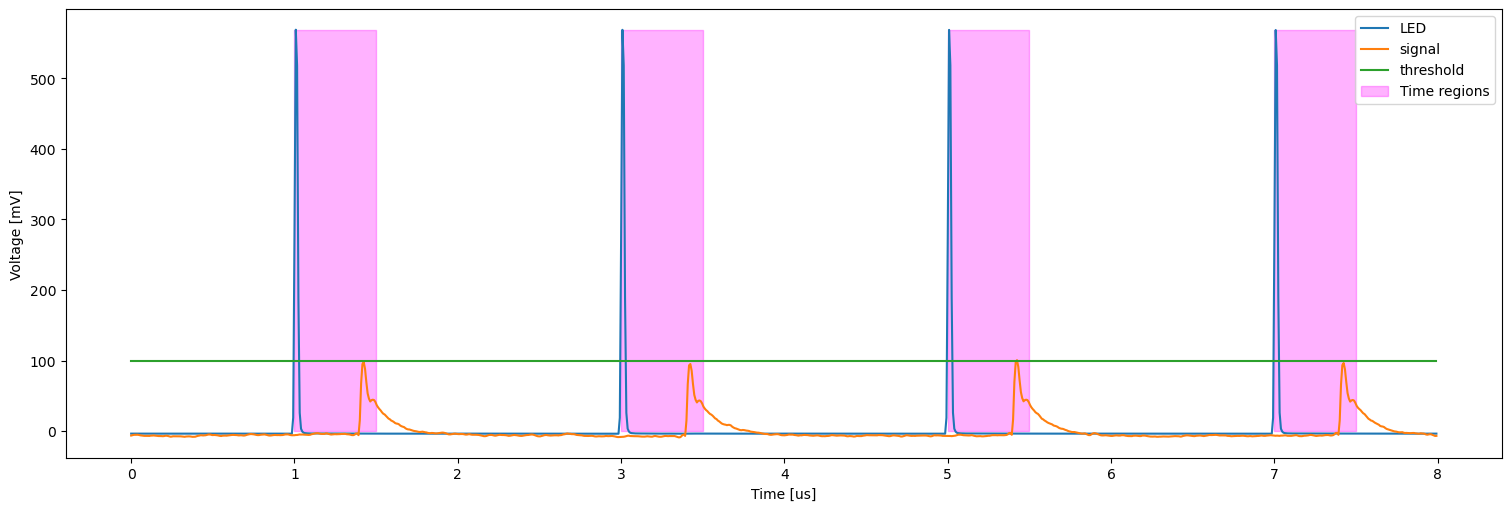

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

t_matrix = []
LED_matrix = []
signal_matrix = []

for frame in range(n_frames):
    
    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    t_matrix.append(wave[:, 0]*time_bin) # [us]
    LED_matrix.append(wave[:, 1]) # [mV]
    signal_matrix.append(wave[:, 2]) # [mV]

x_ax = t_matrix[0]
    
ax.plot(x_ax, np.mean(LED_matrix,axis=0), label = 'LED')
ax.plot(x_ax, np.mean(signal_matrix,axis=0), label = 'signal')

# ax.plot(t0*np.ones(len(x_ax)), np.mean(LED_matrix,axis=0), '-m', alpha = 0.3, label = 'Time regions') 
# ax.plot(tf*np.ones(len(x_ax)), np.mean(LED_matrix,axis=0), '-m', alpha = 0.3) 
n_peaks = 4

for peak in range(n_peaks):
    if peak == 0:
        ax.fill_between([(t0 + peak*period), tf + peak*period], np.mean(LED_matrix,axis=0).max(), 
                        color = 'magenta', alpha = 0.3, label = 'Time regions') 
    else:
        ax.fill_between([(t0 + peak*period), tf + peak*period], np.mean(LED_matrix,axis=0).max(), 
                        color = 'magenta', alpha = 0.3) 

ax.plot(x_ax, th*np.ones(n_points), label = 'threshold')

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.legend(loc = 'best')



Here we have col0=index, col1=LED, col2=signal

We'll take as time data the difference between LED and Signal when both reach a threshold like 100mV

### Waveform

In [9]:
frame = int(n_frames/2)
frame = 1
frame = 100
frame = int(n_frames) - 1
frame = 560
# frame = 660
frame = 4139

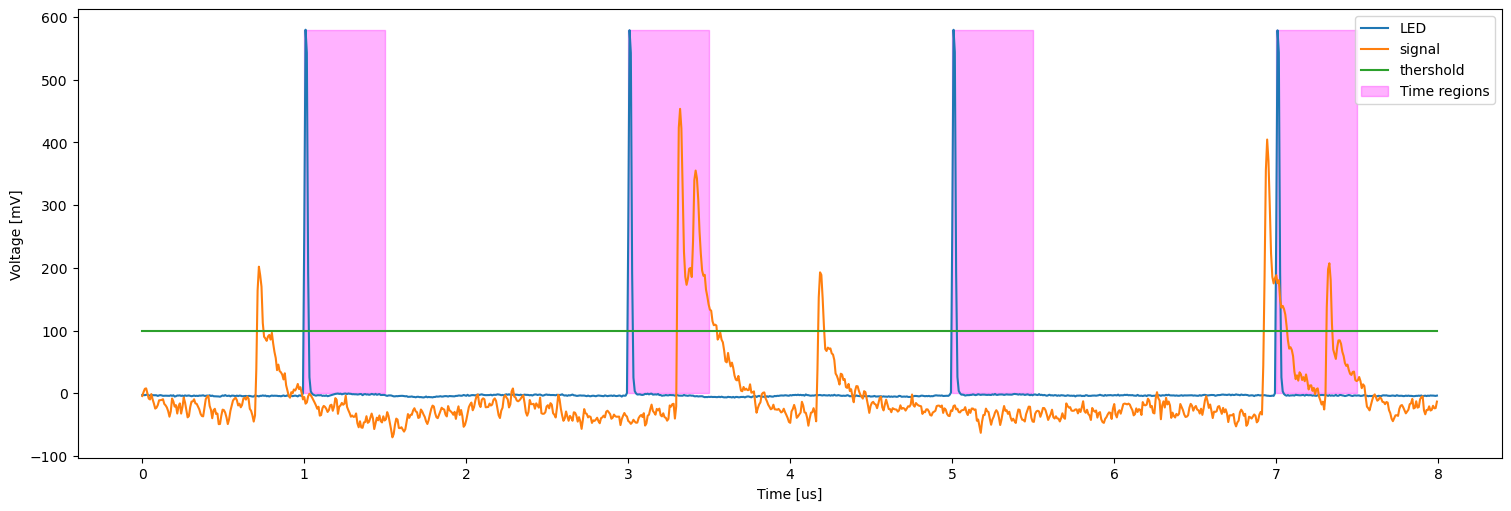

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

# x_ax = wave[:, 0]
# ax.plot(x_ax, wave[:, 1], label = 'LED')
# ax.plot(x_ax, wave[:, 2], label = 'Signal')


# t = wave[:, 0]*time_bin # [us]
t = np.array(range(len(wave)))*time_bin # [us]
# t = wave[:, 0] # [index]
LED = wave[:, 1] # [mV]
signal = wave[:, 2] # [mV]

n_peaks = 4

for peak in range(n_peaks):
        ax.fill_between([(t0 + peak*period), tf + peak*period], LED.max(), 
                    color = 'magenta', alpha = 0.3, label='Time regions' if peak == 0 else "") 

ax.plot(t, LED, label = 'LED')
ax.plot(t, signal, label = 'signal')
ax.plot(t, th*np.ones(len(t)), label = 'thershold')

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.legend(loc = 'best')

frame =  4139
no signal peaks at LED peak  0
no signal peaks at LED peak  2
dt =  [0.304 0.312]


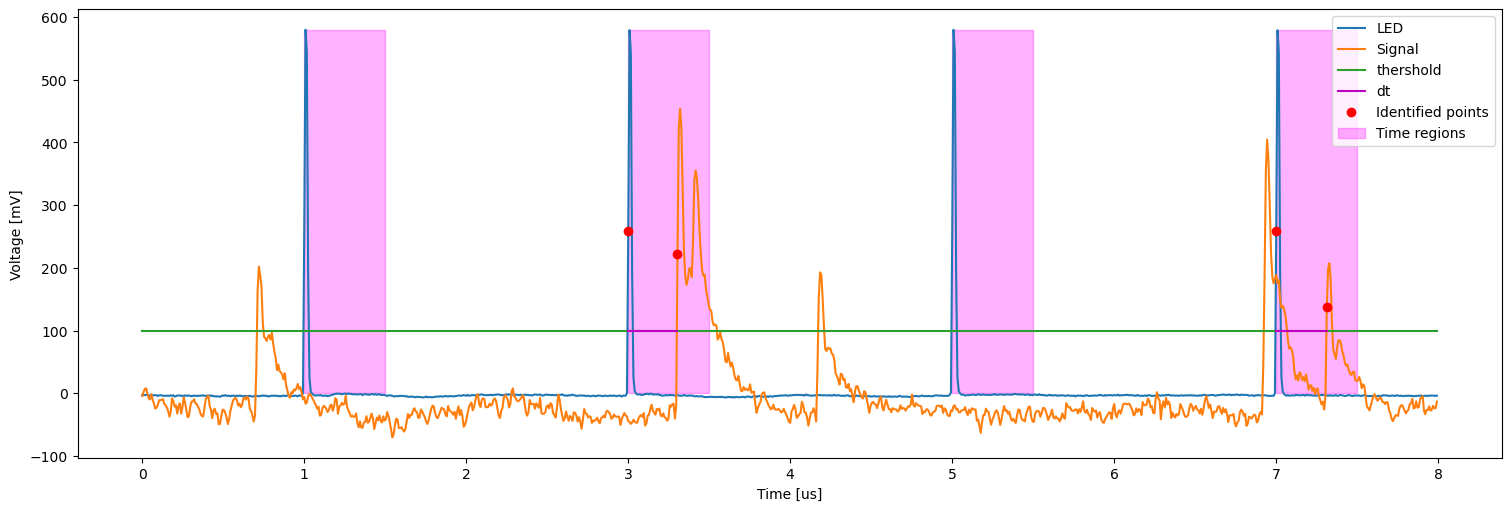

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

print('frame = ', frame)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    
t = wave[:, 0]*time_bin # [us]
LED = wave[:, 1] # [mV]
signal = wave[:, 2] # [mV]

ax.plot(t, LED, label = 'LED')
ax.plot(t, signal, label = 'Signal')
ax.plot(t, th*np.ones(len(t)), label = 'thershold')

n_peaks = 4

for peak in range(n_peaks):
        ax.fill_between([(t0 + peak*period), tf + peak*period], LED.max(), 
                    color = 'magenta', alpha = 0.3, label='Time regions' if peak == 0 else "") 

t_LED_th = []
t_signal_th = []

v_LED_th = []
v_signal_th = []

for peak in range(n_peaks):
    
    t1 = int((t0 + peak*period)/time_bin)
    t2 = int((tf + peak*period)/time_bin)
    
    t = wave[t1:t2, 0]*time_bin # [us]
    LED = wave[t1:t2, 1] # [mV]
    signal = wave[t1:t2, 2] # [mV]
    
#     if signal.max() < th: 
#         print('no signal peaks at LED peak ', peak)
#         continue

    mask_LED = (LED >= th)
    time_after_LED = t > (t[mask_LED][0] + 0.15)

    if signal[time_after_LED].max() < th: 
        print('no signal peaks at LED peak ', peak)
        continue

    mask_signal = (signal[time_after_LED] >= th)

    t_LED_th.append(t[mask_LED][0])
    t_signal_th.append(t[time_after_LED][mask_signal][0])

    v_LED_th.append(LED[mask_LED][0])
    v_signal_th.append(signal[time_after_LED][mask_signal][0])

dt = np.fabs(np.array(t_signal_th) - np.array(t_LED_th))
print('dt = ', dt)

ax.plot(np.linspace(t_LED_th, t_signal_th, len(t)), th*np.ones(len(t)), '-m', label = 'dt')
ax.plot([t_LED_th, t_signal_th], [v_LED_th, v_signal_th], 'or', label = 'Identified points')

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');

hand, labl = ax.get_legend_handles_labels()
hand, labl = np.array(hand), np.array(labl)
not_duplicated = ~pd.DataFrame(labl).duplicated()

ax.legend(hand[not_duplicated], labl[not_duplicated])
# ax.legend(loc = 'best')

In [12]:
t = wave[t1:t2, 0]*time_bin # [us]
signal = wave[t1:t2, 2] # [mV]

time_after_LED = t > (t[mask_LED][0] + 0.1)

mask_signal = (signal[time_after_LED] >= th)


t[time_after_LED]
signal[time_after_LED].max() < th
# signal[time_after_LED].max()
t[time_after_LED][mask_signal]

array([7.312, 7.32 , 7.328, 7.336, 7.344])

In [13]:
dt

array([0.304, 0.312])

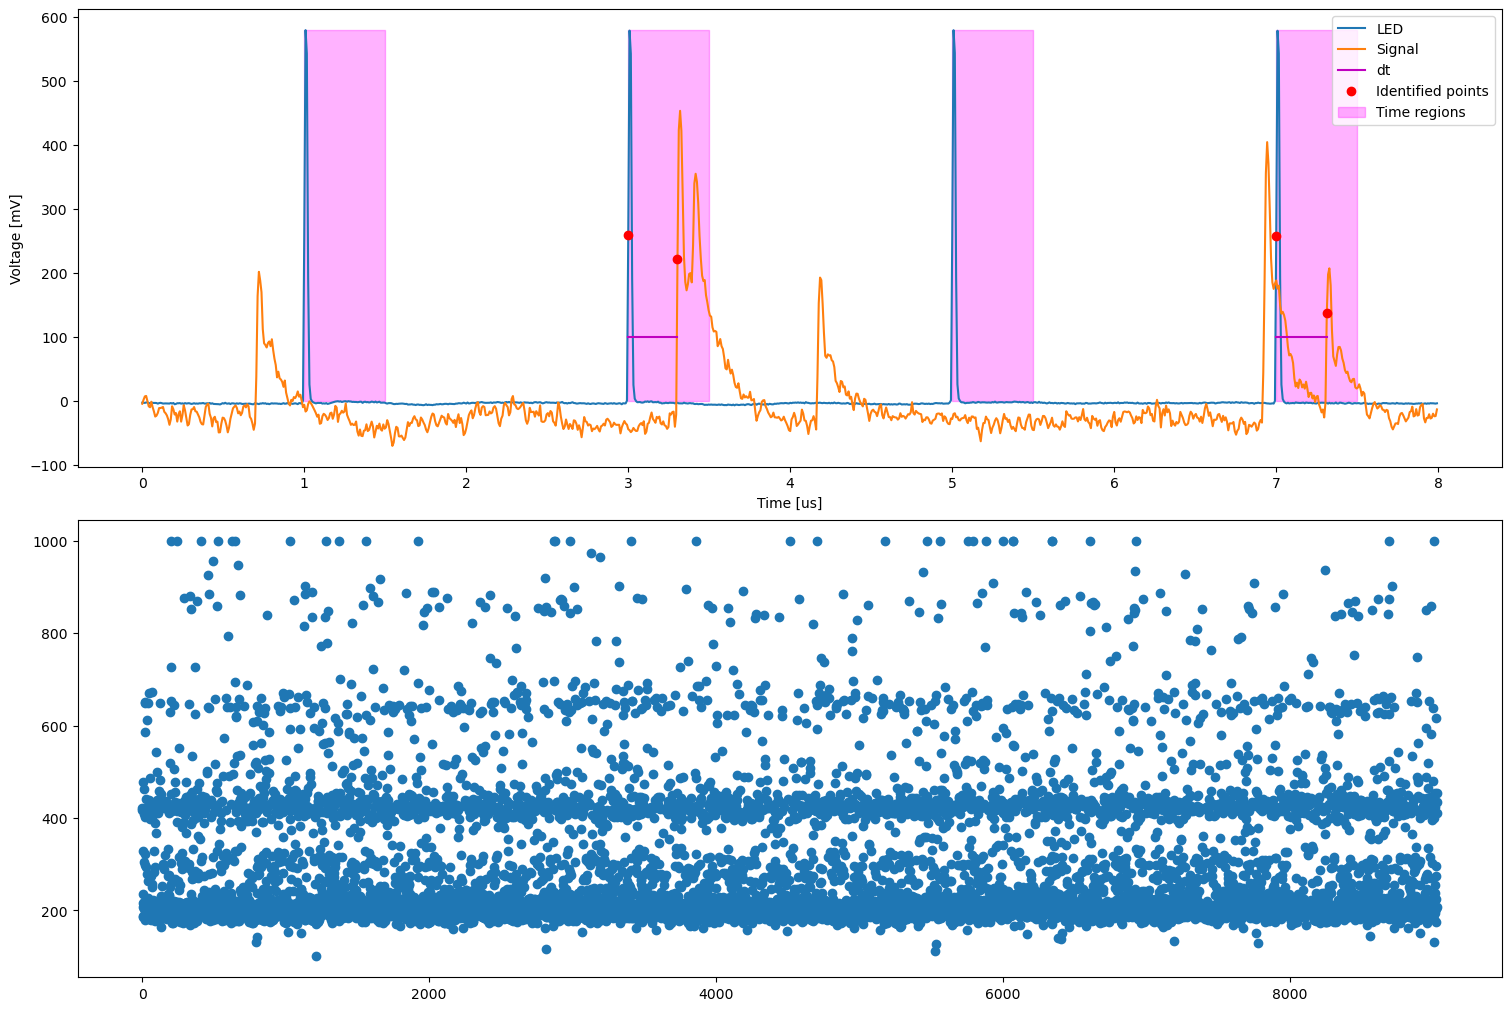

In [14]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

dt = []
s_peak = []

for frame in range(n_frames):
    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

    t_LED_th = []
    t_signal_th = []

    v_LED_th = []
    v_signal_th = []

    for peak in range(n_peaks):

        t1 = int((t0 + peak*period)/time_bin)
        t2 = int((tf + peak*period)/time_bin)

        t = wave[t1:t2, 0]*time_bin # [us]
        LED = wave[t1:t2, 1] # [mV]
        signal = wave[t1:t2, 2] # [mV]

        mask_LED = (LED >= th)
        time_after_LED = t > (t[mask_LED][0] + 0.15)

        if signal[time_after_LED].max() < th: 
#             print('no signal peaks at LED peak ', peak)
            continue
    
        mask_signal = (signal[time_after_LED] >= th)

        t_LED_th.append(t[mask_LED][0])
        t_signal_th.append(t[time_after_LED][mask_signal][0])

        v_LED_th.append(LED[mask_LED][0])
        v_signal_th.append(signal[time_after_LED][mask_signal][0])
        
        s_peak.append(signal.max())
#         dt.append(np.fabs(t[mask_LED][0] - t[mask_signal][0]))
        dt.append(t[mask_LED][0] - t[time_after_LED][mask_signal][0])
    
    
dt = np.array(dt)
s_peak = np.array(s_peak)
    

# plot settings____________________________________________________________________________________
t = wave[:, 0]*time_bin # [us]
LED = wave[:, 1] # [mV]
signal = wave[:, 2] # [mV]

ax[0].plot(t, LED, label = 'LED')
ax[0].plot(t, signal, label = 'Signal')

n_peaks = 4

for peak in range(n_peaks):
        ax[0].fill_between([(t0 + peak*period), tf + peak*period], LED.max(), 
                    color = 'magenta', alpha = 0.3, label='Time regions' if peak == 0 else "") 

ax[0].plot(np.linspace(t_LED_th, t_signal_th, len(t)), th*np.ones(len(t)), '-m', label = 'dt')
ax[0].plot([t_LED_th, t_signal_th], [v_LED_th, v_signal_th], 'or', label = 'Identified points')

ax[0].set_ylabel('Voltage [mV]');
ax[0].set_xlabel('Time [us]');

hand, labl = ax[0].get_legend_handles_labels()
hand, labl = np.array(hand), np.array(labl)
not_duplicated = ~pd.DataFrame(labl).duplicated()

ax[0].legend(hand[not_duplicated], labl[not_duplicated])
# ax.legend(loc = 'best')

ax[1].plot(s_peak, 'o')
# ax[1].set_xlim([7.2e-7, 7.8e-7])
# ax[1].set_ylim([s_peak.min(), 150])

### Time & energy resolutions calculation

#### Peaks energy determination

We need to separate the time information for different peaks 

In [15]:
nn = int(len(waveform[:, 0])/len(waveform[:250, 0]))

wxf_peak = np.hstack([waveform[:250, 0]]*nn)

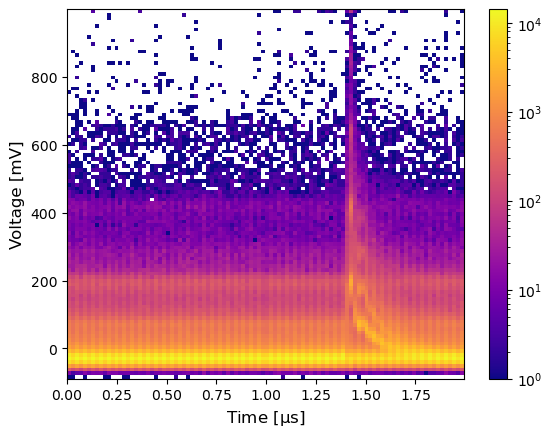

In [16]:
from matplotlib import colors
import copy

fig, ax = plt.subplots(1,1)
# my_cmap = copy.copy(colormaps['plasma']) # copy the default cmap
# my_cmap.set_bad(my_cmap.colors[0])


t1 = int(t0/time_bin)
t2 = int(tf/time_bin)

# counts, xedges, yedges, im = ax.hist2d(np.hstack(waveform[t1:t2, 0]*time_bin), np.hstack(waveform[t1:t2, 2]), 
# counts, xedges, yedges, im = ax.hist2d(waveform[:, 0]*time_bin, waveform[:, 2], 
counts, xedges, yedges, im = ax.hist2d(wxf_peak*time_bin, waveform[:, 2], 
                                       bins=100,# rasterized=True, 
#                                        range=((waveform[:, 0].min(),waveform[:, 0].max()), (-30,150)), 
#                                        range=((0, 2.5), (waveform[:, 2].min(),waveform[:, 2].max())), 
#                                        range=((0, 5), (0, 900)), 
                                       cmap='plasma', norm=colors.LogNorm(), cmin = 0)
#                                        cmap='plasma', vmin = 0)

# im.set_cmin(1)

ax.set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
ax.set_ylabel("Voltage [mV]", size='larger')

# ax.set_xlim([7.2e-7, 7.8e-7])
# ax.set_ylim([-10, 200])

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

In [112]:
signal_1pe = 100 # [mV]
signal_2pe = 200 # [mV]
signal_3pe = 450 # [mV]

# signal_1pe = 20 # [mV]
# signal_2pe = 55 # [mV]
# signal_3pe = 80 # [mV]
# signal_4pe = 110 # [mV]


#### Peaks separation

In [118]:
t_half_peak = []
s_half_peak = []
s_peak = []

for frame in range(n_frames):
    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()

#     if wave[:, 2].max() == waveform_saturation: 
#         continue
    
    signal = wave[:, 2]*1e3
    t = wave[:, 0]
    dt = t[1] - t[0]

#     mask = np.fabs(signal - signal.max()/2.) < 1.55
#     mask = np.fabs(signal - signal.max()/2.) < 3e3
    args = (-signal).argsort()
    arg_threshold = args > 3 
    args = args[arg_threshold]
    
    idx_max = args[0]
    
    search_region_min = max(idx_max - 10, 1)
    search_region_max = idx_max 
    idx = search_region_min + np.fabs(signal[search_region_min : search_region_max] - signal[idx_max]/2.).argmin()

    t_half_peak.append(t[idx])
    s_half_peak.append(signal[idx])
    
#     t_half_peak.append(t[mask][0])
#     s_half_peak.append(signal[mask][0])

    s_peak.append(signal[idx_max])
    
t_half_peak = np.array(t_half_peak)
s_half_peak = np.array(s_half_peak)
s_peak = np.array(s_peak)

In [119]:
signal_pe = [s_peak.min(), signal_1pe, signal_2pe, signal_3pe, s_peak.max()] # [mV]
# signal_pe = [s_peak.min(), signal_1pe, signal_2pe, signal_3pe, signal_4pe, s_peak.max()] # [mV]
# signal_pe = [20, 60, 80, 110] # [mV]

n_pe = len(signal_pe) - 2 # to remove the 2 extremes

# dV = [s_peak.min()] # [mV]
dV = [] # [mV]

# for i in range(1, n_pe+1):
for i in range(0, n_pe+1):
    dV.append((signal_pe[i+1] + signal_pe[i])/2)
    
dV.append(s_peak.max())
    
mask_pe = []
for i in range(n_pe+1):
#     mask_pe.append(np.fabs(s_peak - signal_pe[i]) <= dV) # for fixed dV
    
    mask_pe.append(((s_peak > dV[i]) & (s_peak < dV[i+1])))
        

In [120]:
signal_pe

[640.879, 100, 200, 450, 999985.0]

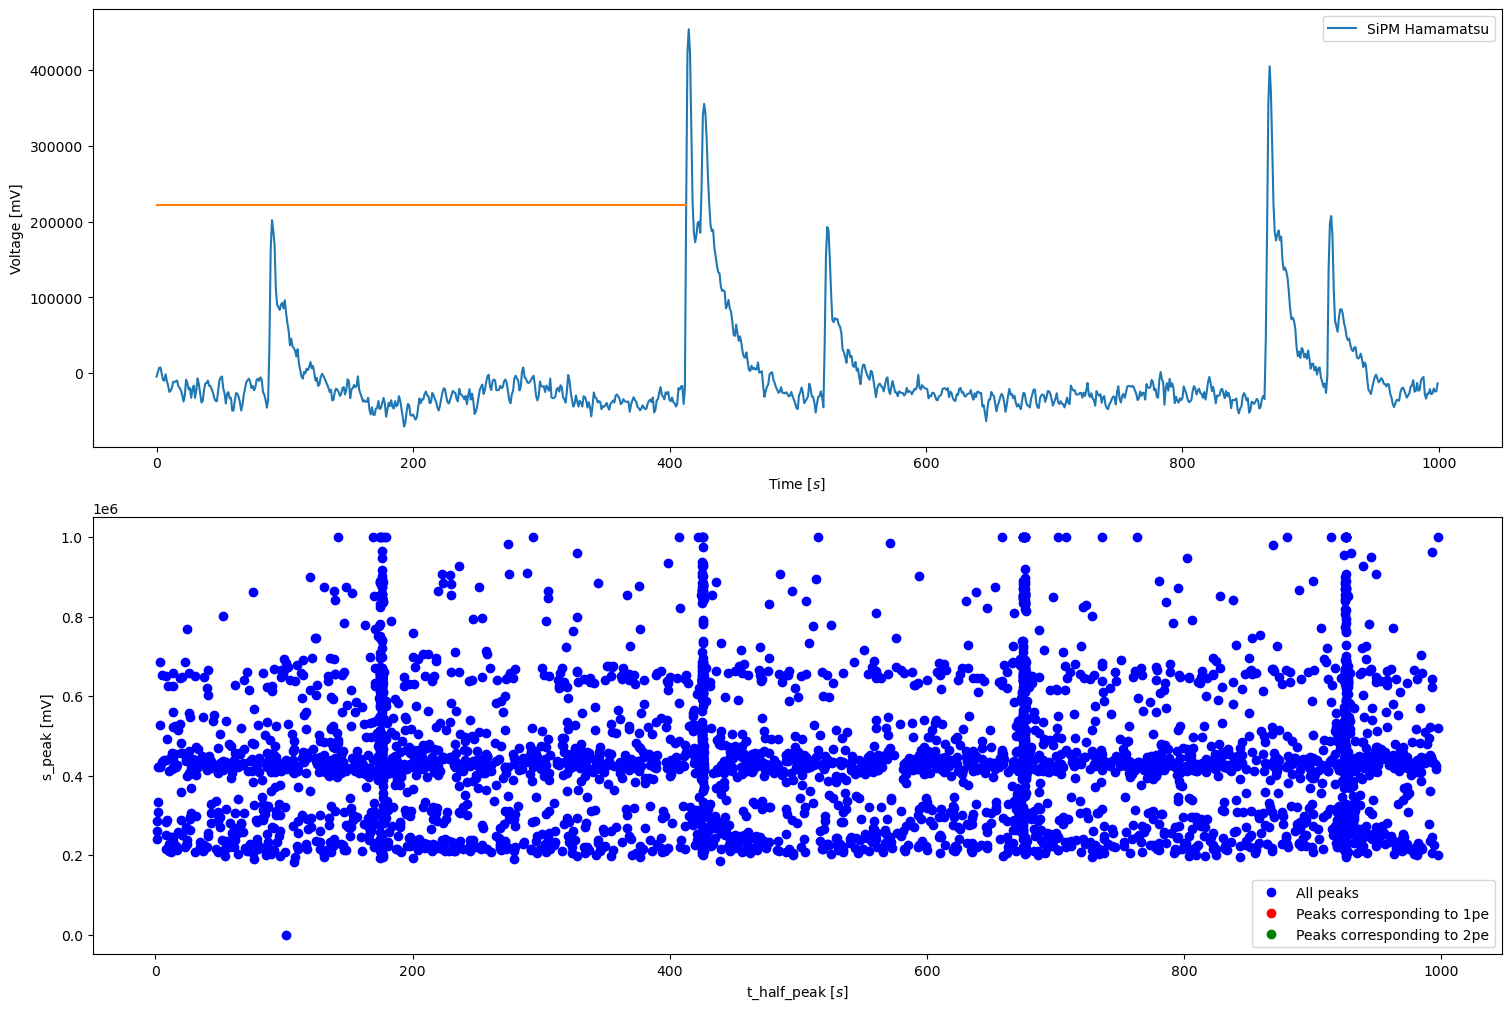

In [116]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)
    
#______________________plot settings________________________________________________________

ax[0].plot(t, signal, label = 'SiPM Hamamatsu')
ax[0].plot(np.linspace(t.min(), t_half_peak[-1], len(t)), s_half_peak[-1]*np.ones(len(t)))

ax[0].set_ylabel('Voltage [mV]');
ax[0].set_xlabel('Time [$s$]');
ax[0].legend(loc = 'best')

ax[1].plot(t_half_peak, s_peak, 'ob', label = 'All peaks')
ax[1].plot(t_half_peak[mask_pe[0]], s_peak[mask_pe[0]], 'or', label = 'Peaks corresponding to 1pe')
ax[1].plot(t_half_peak[mask_pe[1]], s_peak[mask_pe[1]], 'og', label = 'Peaks corresponding to 2pe')
ax[1].plot(t_half_peak[mask_pe[2]], s_peak[mask_pe[2]], 'ok', label = 'Peaks corresponding to 3pe')
# ax[1].plot(t_half_peak[mask_pe[3]], s_peak[mask_pe[3]], 'om', label = 'Peaks corresponding to 4pe')

ax[1].set_ylabel('s_peak [mV]');
ax[1].set_xlabel('t_half_peak [$s$]');

# ax[1].set_xlim([7.2e-7, 7.8e-7])
# ax[1].set_ylim([s_peak.min(), 150])
ax[1].legend(loc = 'best')

In [106]:
s_peak

array([493477., 478584., 328374., ..., 602884., 411749., 453559.])

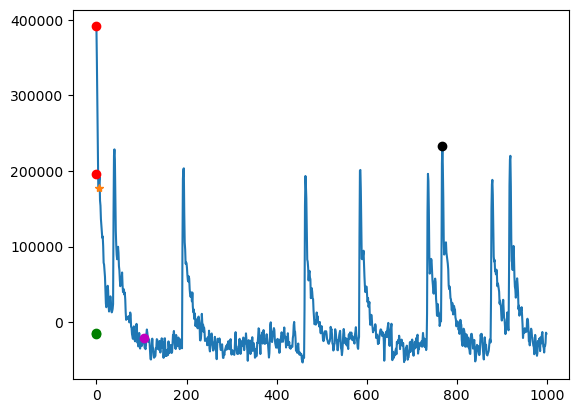

In [102]:
plt.plot(signal)
plt.plot(np.where(signal == signal.max()), signal.max(), 'or')
plt.plot(np.where(signal == signal.max()), signal.max()/2, 'or')
prev = int(np.where(signal == signal.max())[0] - 1)
plt.plot(prev, signal[prev], 'og')
prev = int(np.where(signal == signal.max())[0] - 2)
plt.plot(prev, signal[prev], 'og')
plt.plot(idx, signal[idx], 'om')
plt.plot(5, signal[5], '*')
plt.plot(((-signal).argsort()[(-signal).argsort()>10][0]), 
         signal[((-signal).argsort()[(-signal).argsort()>5][0])], 'ok')

In [85]:
np.fabs(signal[search_region_min : search_region_max] - signal.max()/2.)
signal[: search_region_max]
# search_region_min
search_region_max
signal[1:2]
signal[:1]


array([391028.])

In [101]:
(-signal).argsort()[0] or ((-signal).argsort()[(-signal).argsort()>5][0])
# signal.argmax()

768

In [49]:
np.fabs(signal - signal.max()/2.).min(), signal.max()/2 - signal[prev]

(10574.5, 50949.5)

In [69]:
max_idx = signal.argmax()
idx = max_idx - 20 + np.fabs(signal[max_idx - 20 : max_idx] - signal.max()/2.).argmin()
signal.max()/2  

signal[idx]

180728.0

In [54]:
t[mask].size 

0

In [66]:
signal.argmax()

148

In [44]:
np.where(signal == signal.max())[0] - 1

array([147])

#### Time resolution calculation

In [ ]:
1%2
for pe in range(10):
    print((pe*(pe-1)/2.)%2)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

for pe in range(n_pe):
    n_row = int((pe*(pe-1)/2.)%2) # 0,0,1,1,0,0...
    n_col = int((1 + (-1)**(pe + 1))/2.) #0,1,0,1,0,1...
    
    events, bins, bars = ax[n_row, n_col].hist(t_half_peak[mask_pe[pe]], 100, 
                                     density=False, range=(7e-7, 8e-7),
                                     label='t_half_peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # gaussian fit

#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 0], [2, 1e-6, 1e-6])) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1.5e-7, 7.5e-7, 7e-9]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2E, $\sigma$ = %.2E'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=15, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('t_half_peak [s]')

    ax[n_row, n_col].legend(fontsize=10, loc='best')

#     print('n_pe = ', pe)
#     print('Amplification = ', '%.2E'%(a))
#     print('Mean value = ', '%.2E'%(mu))
#     print('Std = %.2E \n'%(sigma))


#### Energy resolution calculation

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True)

for pe in range(n_pe):
    n_row = int((pe*(pe-1)/2.)%2) # 0,0,1,1,0,0...
    n_col = int((1 + (-1)**(pe + 1))/2.) #0,1,0,1,0,1...
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[mask_pe[pe]], 50, 
                                     density=False, #range=(7e-7, 8e-7),
                                     label='s_peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # gaussian fit

#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 0], [2, 1e-6, 1e-6])) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1.5e-7, 7.5e-7, 7e-9]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2E, $\sigma$ = %.2E'%(mu, sigma))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=15, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('s_peak [mV]')

    ax[n_row, n_col].legend(fontsize=10, loc='best')

#     print('n_pe = ', pe)
#     print('Amplification = ', '%.2E'%(a))
#     print('Mean value = ', '%.2E'%(mu))
#     print('Std = %.2E \n'%(sigma))
